# Example: the EMRI mass function.

In this notebook, we validate a 1-dimensional population Fisher-matrix for the spectral index of the EMRI mass function against numerical MCMC results. In this case we assume individual events are characterised by two parameters - an SNR and the mass. This allows us to more easily introduce heteroscedastic errors.

The model is similar the [tutorial here](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb). As a result, the code will not be as heavily commented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import matplotlib as mpl
import seaborn as sns
import time

import arviz as az
from scipy.special import erfc
from scipy.special import erf
from sympy.parsing import mathematica as M


#from MCMC_PowerLawWithSNRDist   import * # Import utils to perform the MCMC analysis.
#from Fisher_PowerLawWithSNRDist import * # Import utils to calculate the Fisher estimates.


%matplotlib inline
np.random.seed(123)
az.style.use("arviz-darkgrid")


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

#mpl.rcParams.update(params)

In [184]:
# These functions will be removed and become the file MCMC_PowerLawWithSNRDist.py . We 
# include them here at the moment for ease of debugging.

def model_M(M,alpha,M_max, M_min):

    """
    Model for p(M|lambda).
    
    """

    norm  = alpha/(M_max**alpha-M_min**alpha)


    return norm*M**(alpha-1)

def log_M(alpha, N, Mmax,Mmin):

    """
    Analytical function to draw samples following a power law.
    
    Inputs:
    
    - alpha: the spectral index chosen.
    - N: the number of events of the true underlying population.
    - Mmax, Mmin: limits of integration, the minimum and maximum mass of underlying pop.    
    """

    return alpha**-1 * np.log((Mmax**(alpha)-Mmin**(alpha))*np.random.uniform(size=N)+ Mmin**(alpha)*np.ones(N))

def rho(u_vals, M_vals):

    """
    Function to draw samples from the SNR distribution, conditioned on M.
    """

    return (M_vals/(dmax*((1.0-u_vals)**(1./3.))))

def rho_norm(rhomin_inv, rhomax_inv):

    return ((rhomin_inv**3)-(rhomax_inv**3))


def selection_function(Lambda,delta_u,Mmin,Mmax,dmax,threshold):

    """
    Compute selection function.
    """
    norm=0.5*delta_u*Lambda/((dmax**3)*(3.0+Lambda)*(Mmax**Lambda-Mmin**Lambda))
    u_vals=np.arange(0.,1.,delta_u)
    low_samps_I=Mmin/(dmax*((1.-(1.-((Mmin/Mmax)**3))*u_vals)**(1./3.)))
    #print(low_samps)
    low_norm_I=rho_norm(dmax/Mmin,dmax/Mmax)
    low_samps_II=(((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)*u_vals+(Mmin/dmax)**Lambda)**(1./Lambda)
    low_norm_II=3.*((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)/Lambda
    high_samps=Mmax/(dmax*((1.-u_vals)**(1./3.)))
    high_norm=rho_norm(dmax/Mmax,0.)

    
    low_int_I=np.sum((-Mmin**(3+Lambda))*erfc((threshold-low_samps_I)/np.sqrt(2.)))
    #low_int_I=(-Mmin**(3+Lambda))*2.0/delta_u
    low_int_II=np.sum((dmax**(3+Lambda))*erfc((threshold-low_samps_II)/np.sqrt(2.)))
    #low_int_II=(dmax**(3+Lambda))*2.0/delta_u
    #print(low_int_I*delta_u)
    #print(low_int_II*delta_u)
    high_int=np.sum(((Mmax)**(3+Lambda)-Mmin**(3+Lambda))*erfc((threshold-high_samps)/np.sqrt(2.)))
    #high_int=(Mmax**(3+Lambda)-Mmin**(3+Lambda))*2.0/delta_u
    #print(high_int*delta_u)
    
    return(norm*(low_int_I*low_norm_I+low_int_II*low_norm_II+high_int*high_norm))

def d_ln_pdet_d_lam(Lambda,delta_u,Mmin,Mmax,dmax,threshold):

    """
    Compute derivative of log(selection function).
    """
    #norm=0.5*delta_u*Lambda/((dmax**3)*(3.0+Lambda)*(Mmax**Lambda-Mmin**Lambda))
    dlnnorm_dlam=1./Lambda-1./(3.+Lambda)-(np.log(Mmax)*(Mmax**Lambda)-np.log(Mmin)*(Mmin**Lambda))/(Mmax**Lambda-Mmin**Lambda)
    
    
    u_vals=np.arange(0.,1.,delta_u)
    low_samps_I=Mmin/(dmax*((1.-(1.-((Mmin/Mmax)**3))*u_vals)**(1./3.)))
    #print(low_samps)
    low_norm_I=rho_norm(dmax/Mmin,dmax/Mmax)
    low_samps_II=(((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)*u_vals+(Mmin/dmax)**Lambda)**(1./Lambda)
    low_norm_II=3.*((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)/Lambda
    high_samps=Mmax/(dmax*((1.-u_vals)**(1./3.)))
    high_norm=rho_norm(dmax/Mmax,0.)

    
    low_int_I=np.sum((-Mmin**(3+Lambda))*erfc((threshold-low_samps_I)/np.sqrt(2.)))
    dint_I_dlam=low_int_I*np.log(Mmin)
    low_int_II=np.sum((dmax**(3+Lambda))*erfc((threshold-low_samps_II)/np.sqrt(2.)))
    dint_II_dlam=np.sum((dmax**(3+Lambda))*np.log(low_samps_II*dmax)*erfc((threshold-low_samps_II)/np.sqrt(2.)))

    high_int=np.sum(erfc((threshold-high_samps)/np.sqrt(2.)))
    dint_high_dlam=high_int*(np.log(Mmax)*(Mmax**(3+Lambda))-np.log(Mmin)*(Mmin**(3+Lambda)))
    high_int*=((Mmax)**(3+Lambda)-Mmin**(3+Lambda))

    intval=low_int_I*low_norm_I+low_int_II*low_norm_II+high_int*high_norm
    dint_dlam=low_norm_I*dint_I_dlam+low_norm_II*dint_II_dlam+high_norm*dint_high_dlam
    
    return(dlnnorm_dlam+dint_dlam/intval)

def d2_ln_pdet_d_lam(Lambda,delta_u,Mmin,Mmax,dmax,threshold):

    """
    Compute second derivative of log(selection function).
    """
    #norm=0.5*delta_u*Lambda/((dmax**3)*(3.0+Lambda)*(Mmax**Lambda-Mmin**Lambda))
    d2lnnorm_dlam=-1./(Lambda**2)+1./((3.+Lambda)**2)-((np.log(Mmax)**2)*(Mmax**Lambda)-(np.log(Mmin)**2)*(Mmin**Lambda))/(Mmax**Lambda-Mmin**Lambda)+((np.log(Mmax)*(Mmax**Lambda)-np.log(Mmin)*(Mmin**Lambda))**2)/((Mmax**Lambda-Mmin**Lambda)**2)
    
    
    u_vals=np.arange(0.,1.,delta_u)
    low_samps_I=Mmin/(dmax*((1.-(1.-((Mmin/Mmax)**3))*u_vals)**(1./3.)))
    #print(low_samps)
    low_norm_I=rho_norm(dmax/Mmin,dmax/Mmax)
    low_samps_II=(((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)*u_vals+(Mmin/dmax)**Lambda)**(1./Lambda)
    low_norm_II=3.*((Mmax/dmax)**Lambda-(Mmin/dmax)**Lambda)/Lambda
    high_samps=Mmax/(dmax*((1.-u_vals)**(1./3.)))
    high_norm=rho_norm(dmax/Mmax,0.)

    
    low_int_I=np.sum((-Mmin**(3+Lambda))*erfc((threshold-low_samps_I)/np.sqrt(2.)))
    dint_I_dlam=low_int_I*np.log(Mmin)
    d2int_I_dlam=dint_I_dlam*np.log(Mmin)
    low_int_II=np.sum((dmax**(3+Lambda))*erfc((threshold-low_samps_II)/np.sqrt(2.)))
    dint_II_dlam=np.sum((dmax**(3+Lambda))*np.log(low_samps_II*dmax)*erfc((threshold-low_samps_II)/np.sqrt(2.)))
    d2int_II_dlam=np.sum((dmax**(3+Lambda))*(np.log(low_samps_II*dmax)**2)*erfc((threshold-low_samps_II)/np.sqrt(2.)))

    high_int=np.sum(erfc((threshold-high_samps)/np.sqrt(2.)))
    dint_high_dlam=high_int*(np.log(Mmax)*(Mmax**(3+Lambda))-np.log(Mmin)*(Mmin**(3+Lambda)))
    d2int_high_dlam=high_int*((np.log(Mmax)**2)*(Mmax**(3+Lambda))-(np.log(Mmin)**2)*(Mmin**(3+Lambda)))
    high_int*=((Mmax)**(3+Lambda)-Mmin**(3+Lambda))

    intval=low_int_I*low_norm_I+low_int_II*low_norm_II+high_int*high_norm
    dint_dlam=low_norm_I*dint_I_dlam+low_norm_II*dint_II_dlam+high_norm*dint_high_dlam

    d2int_dlam=low_norm_I*d2int_I_dlam+low_norm_II*d2int_II_dlam+high_norm*d2int_high_dlam
    
    return(d2lnnorm_dlam-(dint_dlam/intval)**2+d2int_dlam/intval)


def log_likelihood(params, data, weights, hyperprior_min, hyperprior_max, delta_u, M_max, M_min, rho_th, dmax, N_det):

    """
    Function for the population log-likelihood.
    
    Inputs:
    
    - params: the parameter to sample through. 
    - data: the data to be analysed. In this case data[i,j] is the j'th posterior sample for the i'th event.
    - weights: weights for each posterior sample in data, obtained by marginalising out the SNR.
    - hyperprior_min and max: the lower and upper limits of the priors of the parameter.
    - delta_u: step size to use for integration of the selection function.
    - M_max, M_min: the upper and lower limits for the source parameter.
    - rho_th: threshold for the observability of data.
    - dmax: maximum distance of a source in the population. We use this to ensure integrability of the SNR distribution.
    - N_det: number of detected events.
    """

    # Build up support for posteriors.
    support = (
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
   
    log_likelihood=0

    # Include the selection function.
    pdet = selection_function(params[0],delta_u,Mmin,Mmax,dmax,rho_th)
    Nsources = N_det


    # Write down the population likelihood here.
    for i in np.arange(Nsources):

        ppop_ij = model_M(data[i,:],params[0],M_max, M_min)         # N_samp-long array for population model.
        sum_ppop = np.sum(weights[i,:]*ppop_ij)                     # Internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop/pdet)                     # Add the samples drawn over N_obs in the loop by the selection function at each step.


    #Output without infinities and within the specified hyperpriors (only retain output if supported).
    out = np.where(support,log_likelihood,-np.inf)


    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf
                                                                         


### Generate data

The data are generated in the same way as the tutorial, with a spectral index that is flat in the log of the masses and lower and upper limits $10^4 M_\odot < M < 10^7 M_\odot$.

In [461]:
#Parameters

N_obs_targ = 500
N_samps_likelihoods = 1000
delta_u_selfunction = 0.0001 

alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min) # M runs from 10^4
M_max=10000000.; logM_max = np.log(M_max) # to 10^7 solar masses.

rho_th=10
dmax=Mmax/(rho_th-3)

N_tries = np.int(N_obs_targ/selection_function(alpha0_t,delta_u_selfunction,Mmin,Mmax,dmax,rho_th))

#Generate a population

sig_M = 10. # uncertainty in mass measurement
#sig_M=0.001

In [476]:
Mvals=np.exp(log_M(alpha0_t,N_tries,Mmax,Mmin))
u_vals=np.random.uniform(size=N_tries)
rho_vals=rho(u_vals,Mvals)
rho_meas=rho_vals+np.random.normal(size=N_tries)

rho_obs=rho_meas[rho_meas>rho_th]
M_final=Mvals[rho_meas>rho_th]
rhoM_obs=rho_vals[rho_meas>rho_th]*M_final + sig_M*np.random.normal(size=len(M_final))
M_obs=rhoM_obs/rho_obs
#print(rho_obs)
#print(M_obs)
N_obs=len(rho_obs)

print('Out of', N_tries,'possible events,', N_obs,'are detected.')


Out of 28370 possible events, 499 are detected.


In [477]:
np.min(rho_obs)

10.014330297472815

In [478]:
"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian with noise variance sigma.
"""

rhoM_post_samps=np.zeros((N_obs,N_samps_likelihoods))
rho_post_samps=np.zeros((N_obs,N_samps_likelihoods))
M_post_samps=np.zeros((N_obs,N_samps_likelihoods))
post_samps_weights=np.zeros((N_obs,N_samps_likelihoods))
for i in np.arange(N_obs):
    rhoM_post_samps[i,:]=np.random.normal(rhoM_obs[i],sig_M,size=N_samps_likelihoods)
    rho_post_samps[i,:]=np.random.normal(rho_obs[i],1.0,size=N_samps_likelihoods)
    M_post_samps[i,:]=rhoM_post_samps[i,:]/rho_post_samps[i,:]
    post_samps_weights[i,:]=1./((rho_post_samps[i,:])**5)
    weight_norm=np.sum(post_samps_weights[i,:])
    post_samps_weights[i,:]/=weight_norm
#print(np.min(post_samps_weights))
#print(np.max(post_samps_weights))
#for i in np.arange(N_obs):
#    print(np.sum(post_samps_weights[i,:]))
#    print(np.max(post_samps_weights[i,:])/np.min(post_samps_weights[i,:]))

Plot the underlying and observed populations.

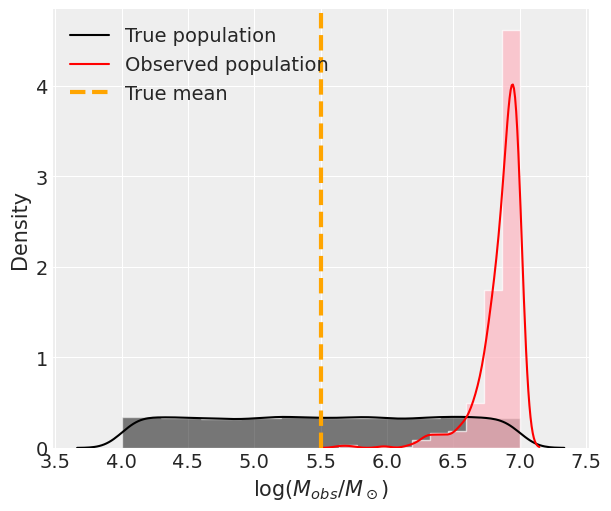

In [479]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(Mvals),density=True,bins=10,histtype = 'stepfilled',
                               color ='black', alpha=0.5, edgecolor='white')
sns.kdeplot(np.array(np.log10(Mvals)), label='True population',c='k')
plt.hist(np.log10(M_final),density=True,bins=10,histtype = 'stepfilled',
                            color ='lightpink', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(M_final)), label='Observed population',c='red')
    
plt.axvline(x=np.log10(np.exp(np.mean(np.log(Mvals)))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

### Fitting

We fit the population likelihood here assuming a flat prior on $\alpha$. We assume that the SNR distribution, for which the density is proportional to 1/rho^4, is known and use the same SNR distribution as our prior. The relevant function for the log_likelihood-- "log_likelihood()" -- is found in MCMC_PowerLawWithSNRDist.py. The argument it requires are fed into the args option in the "EnsembleSampler".

Notice that the "log_likelihood()" function takes into account selection effects. These are obtained solving the following integral with Monte Carlo methods,

  $$p_\text{det}(\lambda) = \int p_\text{det}(\theta) p(\theta|\lambda) d\theta \approx \frac{1}{N_\text{samp}}\sum \frac{p_\text{det}(\theta_{ij})}{2}\text{erfc}\left[\frac{d_\text{th}-\theta_{ij}}{\sqrt{2}\sigma}\right]\quad (\text{with } \theta_{ij}\sim p(\theta|\lambda)).$$

This integration is performed in the "selection_function" function called by "log_likelihood()".

In [480]:
# Limits of (flat) hyperpriors.

hyperprior_min = -100.0
hyperprior_max = 100.0

# Iterations, ndims and walkers.

n_iter = 30000
ndim = 1; nwalkers = 4

# Initialization of the MCMC. Perturb away from true values.

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

# Sampling

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood,
                                args=[M_post_samps,post_samps_weights,hyperprior_min,hyperprior_max,
                                      delta_u_selfunction, M_max, M_min, rho_th, dmax, N_obs]
                               )
run = sampler.run_mcmc(p0, n_iter, progress=True)
alpha_samples_emcee = sampler.get_chain(discard=2000, thin=1, flat=False)


#sampler_10Obs = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood,
#                                args=[M_post_samps,post_samps_weights,hyperprior_min,hyperprior_max,
#                                      delta_u_selfunction, M_max, M_min, rho_th, dmax, 10]
#                               )
#run_10Obs = sampler_10Obs.run_mcmc(p0, n_iter, progress=True)
#alpha_samples_10Obs_emcee = sampler_10Obs.get_chain(discard=2000, thin=1, flat=False)

You must install the tqdm library to use progress indicators with emcee


In [481]:
# Error on hyperparameter from MCMC.
print('Error, all events:',np.sqrt(np.var(alpha_samples_emcee)))
print('Error, ten events:',np.sqrt(np.var(alpha_samples_10Obs_emcee)))
print('Ratio:',np.sqrt(np.var(alpha_samples_emcee)/np.var(alpha_samples_10Obs_emcee)))
print('Predicted ratio:',np.sqrt(10/N_obs))

Error, all events: 0.13578482597428107
Error, ten events: 1.3649577720646886
Ratio: 0.09947914049303344
Predicted ratio: 0.1415629900797544


In [482]:
# Save data
#alpha_samples_emcee_sigM_10=alpha_samples_emcee
#alpha_samples_10Obs_emcee_sigM_10=alpha_samples_10Obs_emcee
#N_obs_sig_M_10 = 83

#alpha_samples_emcee_sigM_0_001=alpha_samples_emcee
#alpha_samples_10Obs_emcee_sigM_0_001=alpha_samples_10Obs_emcee
#N_obs_sig_M_0_001 =N_obs

#alpha_samples_emcee_sigM_10_Ntarg_200_Npost_1000=alpha_samples_emcee
#alpha_samples_10Obs_emcee_sigM_10_Ntarg_200_Npost_1000=alpha_samples_10Obs_emcee
#N_obs_sigM_10_Ntarg_200_Npost_1000=N_obs

#alpha_samples_emcee_sigM_10_Ntarg_500_Npost_1000=alpha_samples_emcee
#N_obs_sigM_10_Ntarg_500_Npost_1000=N_obs

#alpha_samples_emcee_sigM_10_Ntarg_500_Npost_1000_B=alpha_samples_emcee
#N_obs_sigM_10_Ntarg_500_Npost_1000_B=N_obs

# NB All results prior to this had a bug in the data generation - rhoM was centred at 
# \hat{rho} M not rho M.

alpha_samples_emcee_sigM_10_Ntarg_500_Npost_1000_corr=alpha_samples_emcee
N_obs_sigM_10_Ntarg_500_Npost_1000_corr=N_obs



### MCMC results and diagnostics

We run some diagnostics using the arviz package. We gather some interactive data from emcee's results with the following lines.

In [483]:
# define variable names, it cannot be inferred from emcee
var_names = ["alpha"]
burnin = 1000


idata1 = az.from_emcee(sampler, var_names=var_names) # interactive data.
idata2 = idata1.sel(draw=slice(burnin, None), groups="posterior") # interactive data.

Mean and variance from interactive data.

In [484]:
print('Mean:',idata2.posterior.mean())
print('Variance:',idata2.posterior.var())

Mean: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 -0.06139
Variance: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 0.01833


We check the summary statistics and plot trace and posterior here

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.0614,0.1354,-0.3168,0.1938,0.0023,0.0016,3498.7869,9476.6758,1.0018


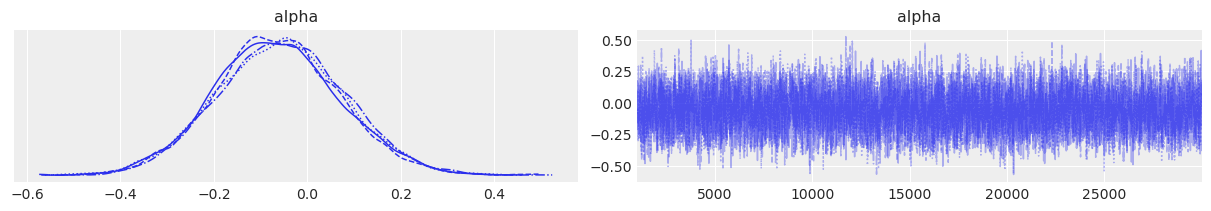

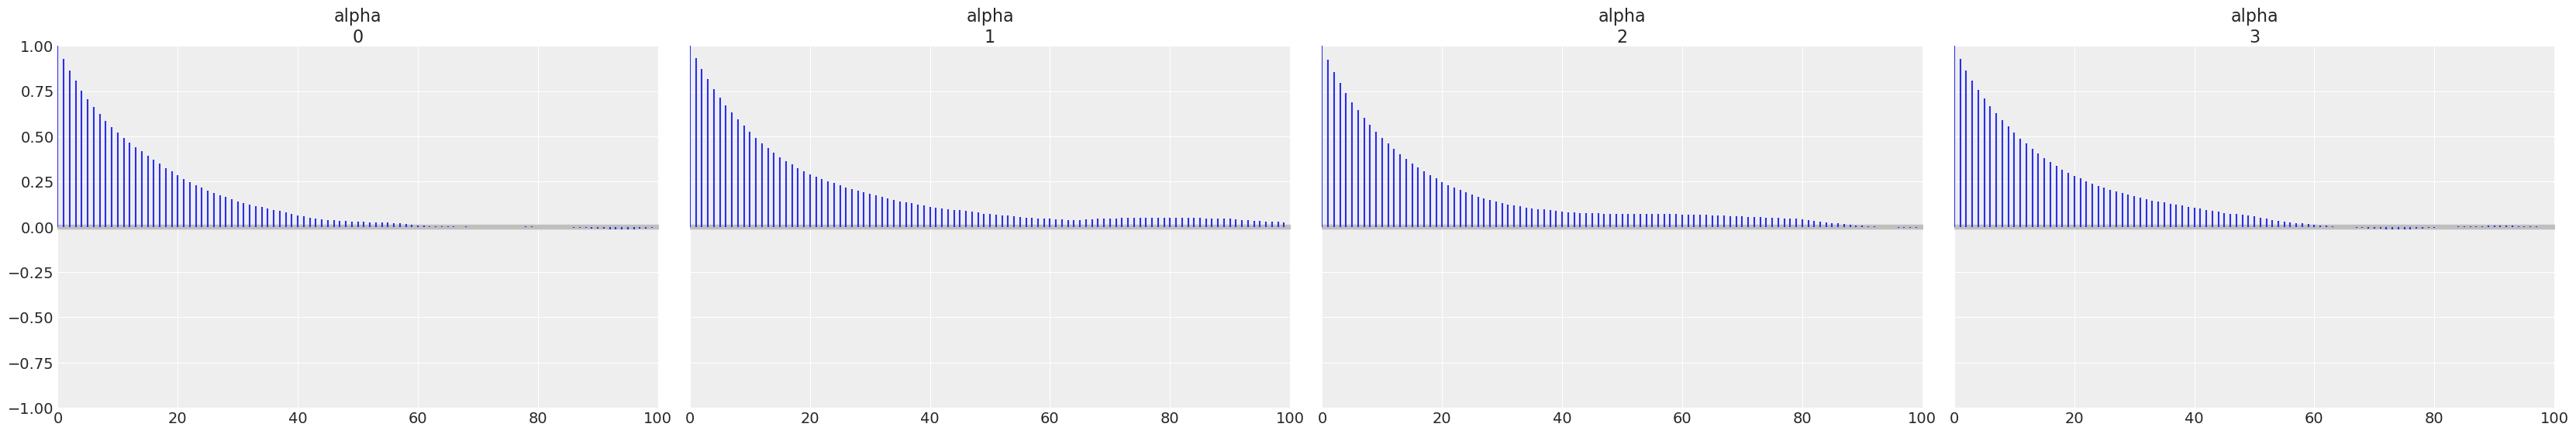

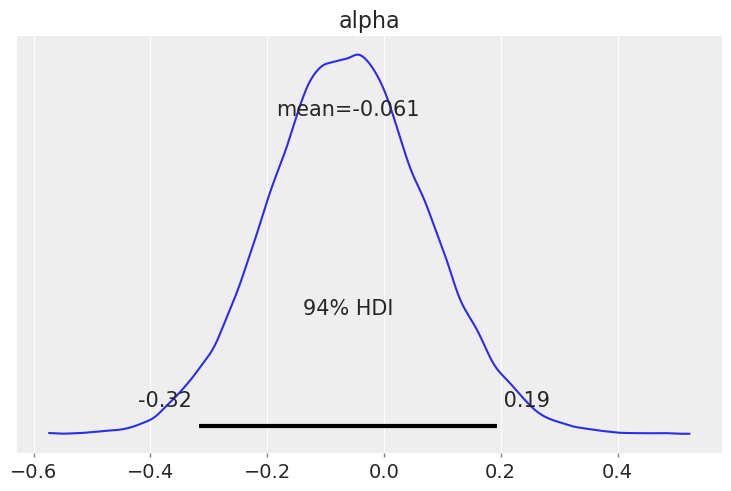

In [485]:
display(az.summary(idata2, round_to=4))         # Summary statistics.
az.plot_trace(idata2, var_names=var_names);     # Plot traces.
az.plot_autocorr(idata2, var_names=var_names);  # Plot autocorrelation.
az.plot_posterior(idata2, var_names=var_names); # Plot posterior distribution.

It is useful to single out the samples for the parameter of interest, which is done as follows:

In [486]:
#Get samples for parameter
stacked = idata1.posterior.stack(draws=("chain", "draw"))
alpha_samples=stacked.alpha.values

Plot the KDE.

/var/folders/zl/8mf26c0n2cdbfrfk_r2vtp6r0000gq/T/ipykernel_55831/3611444380.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().tight_layout()


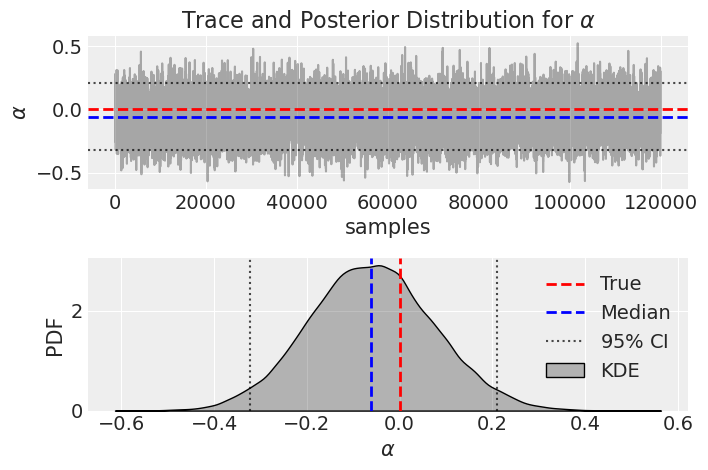

In [487]:
# Get the credible interval, mean and median.
cred_min, cred_max = np.percentile(alpha_samples, 2.5), np.percentile(alpha_samples, 97.5)
median=np.median(alpha_samples)

# Plot Trace
plt.subplot(2,1,1)
plt.plot(alpha_samples,color='k',alpha=0.3)
plt.xlabel('samples')
plt.ylabel(r'$\alpha$')
plt.axhline(alpha0_t, color='r', lw=2, linestyle='--')
plt.axhline(median, color='blue', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.7)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.7)
plt.title('Trace and Posterior Distribution for {}'.format(r'$\alpha$'))

# Plot KDE
plt.subplot(2,1,2)
sns.kdeplot(alpha_samples, shade=True, color='k',label='KDE')
plt.xlabel(r'$\alpha$')
plt.ylabel('PDF')
plt.axvline(alpha0_t, color='r', lw=2, linestyle='--',label='True')
plt.axvline(median, color='blue', lw=2, linestyle='--',label='Median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.7, label=r'$95\%$ CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.7)
  
# Final touches.
plt.gcf().tight_layout()
plt.legend()

### Fisher estimates

This expressions has been coded up for a mono-parametric (but generic) power-law model in the function "FM_1D_powerlaw" function below, which is found in Fisher_PowerLaw.py.

Details as to how this is calculated and implemented are reported in [this note](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/Notes_1D_FM_PowerLaw.ipynb).

In [409]:
def gaussian(d,mu,Sigma_sq):

    # My redefinition of gaussian to take the sigma^2 as input.

    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)

    return num/den

# Normalisation of the population integral for a function scaling as rho^beta M^gamma
def popint_norm(beta,gamma,Lambda,Mmax,Mmin,dmax):
    return(3.*Lambda*((Mmax**(Lambda+beta+gamma))-(Mmin**(Lambda+beta+gamma)))/((3.-beta)*(dmax**beta)*(Lambda+beta+gamma)*((Mmax**Lambda)-(Mmin**Lambda))))

def popint_Mval(u_vals,beta,gamma,Lambda,Mmax,Mmin):
    
    return((u_vals*((Mmax**(Lambda+beta+gamma))-(Mmin**(Lambda+beta+gamma)))+(Mmin**(Lambda+beta+gamma)))**(1./(Lambda+beta+gamma)))

def popint_rhoval(u_vals,beta,M,dmax):
    rhos=(M/dmax)/((1.-u_vals)**(1./(3.-beta)))
    rhos[np.isnan(rhos)]=(M/dmax)/((1.e-7)**(1./(3.-beta)))
    return(rhos)

def det_Gam_plus_H(rho_list,M,Lambda,sigM,rho_th):
    
    return(((rho_list/sigM)**2)+4./(sigM**2)-(2.+Lambda)*(1./(M**2)+1./(sigM**2)+4./((rho_list*M)**2)))

def d_det_Gam_plus_H(rho_list,M,Lambda,sigM,rho_th):
    
    return(-(1./(sigM**2)+1./(M**2)+4./((rho_list*M)**2)))

def GammaII_integrand(rho_list,det_list,d_det_list,M,Lambda,sigM,rho_th):
    
    return(-0.25*((d_det_list/det_list)**2)*erfc((rho_th-rho_list)/np.sqrt(2.)))

def AIII(rho_list,M,Lambda,sigM,rho_th):
    
    return((rho_th-rho_list)*((rho_list**2)/(sigM**2)-(2.+Lambda)/(M**2))*np.exp(-0.5*((rho_list-rho_th)**2))/np.sqrt(2.*np.pi)
           +(2.*(rho_list**2)/(sigM**2)+(2.-Lambda)/(sigM**2)-(2.+Lambda)/(M**2))*0.5*erfc((rho_th-rho_list)/np.sqrt(2.)))

def d_AIII(rho_list,M,Lambda,sigM,rho_th):

    return(-2.*(rho_th-rho_list)*np.exp(-0.5*((rho_list-rho_th)**2))/((M**2)*np.sqrt(2.*np.pi))-(1./(sigM**2)+1./(M**2))*0.5*erfc((rho_th-rho_list)/np.sqrt(2.)))

def AIV(rho_list,M,Lambda,sigM,rho_th):
    
    return(-((6.+Lambda)*rho_list/(sigM**2)+4.*(2.+Lambda)/(rho_list*(M**2)))*np.exp(-0.5*((rho_list-rho_th)**2))/np.sqrt(2.*np.pi))

def d_AIV(rho_list,M,Lambda,sigM,rho_th):

    return((4./(rho_list*(M**2))-rho_list/(sigM**2))*np.exp(-0.5*((rho_list-rho_th)**2))/np.sqrt(2.*np.pi))

def AV(rho_list,M,Lambda,sigM,rho_th):

    return((16./(sigM**2)-16.*(2.+Lambda)/((rho_list*M)**2)+8.*(2.+Lambda)/(sigM**2)+((2.+Lambda)**2)*(4./((rho_list*M)**2)+1./(M**2)+1./(sigM**2)))*0.5*erfc((rho_th-rho_list)/np.sqrt(2.)))

def d_AV(rho_list,M,Lambda,sigM,rho_th):
    
    return((8.*Lambda/((rho_list*M)**2)+2.*(6.+Lambda)/(sigM**2)+2.*(2.+Lambda)/(M**2))*0.5*erfc((rho_th-rho_list)/np.sqrt(2.)))

def d2_AV(rho_list,M,Lambda,sigM,rho_th):
    
    return((8./((rho_list*M)**2)+2./(M**2)+2./(sigM**2))*0.5*erfc((rho_th-rho_list)/np.sqrt(2.)))

def GammaIII_integrand(rho_list,det_list,d_det_list,M,Lambda,sigM,rho_th):
    AIII_list=AIII(rho_list,M,Lambda,sigM,rho_th)
    d_AIII_list=d_AIII(rho_list,M,Lambda,sigM,rho_th)
    
    return(d_det_list*d_AIII_list/(det_list**2)-(d_det_list**2)*AIII_list/(det_list**3))

def GammaIV_integrand(rho_list,det_list,d_det_list,M,Lambda,sigM,rho_th):
    AIV_list=AIV(rho_list,M,Lambda,sigM,rho_th)
    d_AIV_list=d_AIV(rho_list,M,Lambda,sigM,rho_th)
    
    return(2.*(d_det_list*d_AIV_list/(det_list**2)-(d_det_list**2)*AIV_list/(det_list**3)))

def GammaV_integrand(rho_list,det_list,d_det_list,M,Lambda,sigM,rho_th):
    AV_list=AV(rho_list,M,Lambda,sigM,rho_th)
    d_AV_list=d_AV(rho_list,M,Lambda,sigM,rho_th)
    d2_AV_list=d2_AV(rho_list,M,Lambda,sigM,rho_th)
    
    return(d_det_list*d_AV_list/(det_list**2)-(d_det_list**2)*AV_list/(det_list**3)-0.5*d2_AV_list/det_list)


In [397]:
delta_u=0.1
u_vals=np.arange(0.,1.,delta_u)
print(popint_norm(0.,0.,alpha0_t,M_max,M_min,dmax))
print(popint_rhoval(u_vals,0.,Mmax,dmax))
for i in range(len(u_vals)):
    print(u_vals[i])
print(u_vals)

1.0
[ 7.          7.25020918  7.54052142  7.88373516  8.29941771  8.81944735
  9.50046166 10.45661108 11.96983163 15.08104283]
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [412]:
def Gamma_old(alpha,delta_u,M_max,M_min,rho_th,dmax,sigM):
    pdet=selection_function(alpha,delta_u,M_min,M_max,dmax,rho_th)
    
    GammaIa=1./(alpha**2)-np.exp(alpha*(np.log(M_max*M_min))+2.*np.log(np.log(M_max)-np.log(M_min))-2.*np.log(M_max**alpha-M_min**alpha))
    GammaIb=d2_ln_pdet_d_lam(alpha0_t,delta_u,M_min,M_max,dmax,rho_th)

    norm=popint_norm(0.,0.,alpha,M_max,M_min,dmax)
    u_vals=np.arange(0.,1.,delta_u)
    GammaII=0.
    Nus=len(u_vals)
    for i in range(Nus):
        Mval=popint_Mval(u_vals[i],0.,0.,alpha,M_max,M_min)
        v_min=1.-((Mval/(dmax*(rho_th-4.)))**(3.))
        #v_max=1.-((Mval/(dmax*(rho_th+4.)))**(3.))
        v_max=1.
        #print(v_min,v_max)
        delta_v=(v_max-v_min)/10000.
        #print(delta_v)
        #v_vals=np.arange(v_min,v_max,delta_v)
        v_vals=np.arange(v_min,v_max-2.*delta_v,delta_v)
        #print(v_vals[len(v_vals)-1])
        rhos=popint_rhoval(v_vals,0.,Mval,dmax)
        #print(GammaII_integrand(rhos,Mval,rho_th))
        det_list=det_Gam_plus_H(rhos,Mval,alpha,sigM,rho_th)
        d_det_list=d_det_Gam_plus_H(rhos,Mval,alpha,sigM,rho_th)
        GammaII+=delta_v*np.sum(GammaII_integrand(rhos,det_list,d_det_list,Mval,alpha,sigM,rho_th))+(1.-v_max)
    GammaII*=norm*delta_u/pdet 
    return(GammaIa+GammaIb+GammaII)
    #return(GammaIa)
    #return(GammaII)
    
def Gamma(alpha,delta_u,M_max,M_min,rho_th,dmax,sigM):
    pdet=selection_function(alpha,delta_u,M_min,M_max,dmax,rho_th)
    
    GammaIa=1./(alpha**2)-np.exp(alpha*(np.log(M_max*M_min))+2.*np.log(np.log(M_max)-np.log(M_min))-2.*np.log(M_max**alpha-M_min**alpha))
    GammaIb=d2_ln_pdet_d_lam(alpha0_t,delta_u,M_min,M_max,dmax,rho_th)

    norm=popint_norm(0.,0.,alpha,M_max,M_min,dmax)
    u_vals=np.arange(0.,1.,delta_u)
    GammaII=0.
    GammaIII=0.
    GammaIV=0.
    GammaV=0.
    Nus=len(u_vals)
    for i in range(Nus):
        Mval=popint_Mval(u_vals[i],0.,0.,alpha,M_max,M_min)
        v_min=1.-((Mval/(dmax*(rho_th-4.)))**(3.))
        v_max=1.
        delta_v=(v_max-v_min)/10000.
        v_vals=np.arange(v_min,v_max,delta_v)
        rhos=popint_rhoval(v_vals,0.,Mval,dmax)
        det_list=det_Gam_plus_H(rhos,Mval,alpha,sigM,rho_th)
        d_det_list=d_det_Gam_plus_H(rhos,Mval,alpha,sigM,rho_th)
        GammaII+=delta_v*np.sum(GammaII_integrand(rhos,det_list,d_det_list,Mval,alpha,sigM,rho_th))
        GammaIII+=delta_v*np.sum(GammaIII_integrand(rhos,det_list,d_det_list,Mval,alpha,sigM,rho_th))
        GammaIV+=delta_v*np.sum(GammaIV_integrand(rhos,det_list,d_det_list,Mval,alpha,sigM,rho_th))
        GammaV+=delta_v*np.sum(GammaV_integrand(rhos,det_list,d_det_list,Mval,alpha,sigM,rho_th))
    GammaII*=norm*delta_u/pdet
    GammaIII*=norm*delta_u/pdet
    GammaIV*=norm*delta_u/pdet
    GammaV*=norm*delta_u/pdet
    print(GammaIa+GammaIb)
    print(GammaII)
    print(GammaIII)
    print(GammaIV)
    print(GammaV)
    return(GammaIa+GammaIb+GammaII+GammaIII+GammaIV+GammaV)
    #return(GammaIa)
    #return(GammaII)

In [425]:
delta_u=1.e-4
print(Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,30000.))

/var/folders/zl/8mf26c0n2cdbfrfk_r2vtp6r0000gq/T/ipykernel_55831/805308528.py:19: RuntimeWarning: invalid value encountered in power
  rhos=(M/dmax)/((1.-u_vals)**(1./(3.-beta)))


0.1111121839342104
-2.634874391296785e-05
-8.548277676386318e-05
0.0007812668614287247
-0.007155366263715815
0.10462625301124649


In [416]:
print(Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,10.))
print(Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,0.001))
print(selection_function(alpha0_t,delta_u,M_min,M_max,dmax,rho_th))

/var/folders/zl/8mf26c0n2cdbfrfk_r2vtp6r0000gq/T/ipykernel_55831/805308528.py:19: RuntimeWarning: invalid value encountered in power
  rhos=(M/dmax)/((1.-u_vals)**(1./(3.-beta)))


KeyboardInterrupt: 

In [402]:
print(Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,sig_M))
print(Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,10.))
print(alpha0_t)
print(delta_u_selfunction)
delta_alph=1.e-6
delta_u=1.e-6
print((np.log(selection_function(alpha0_t+2.*delta_alph,delta_u,M_min,M_max,dmax,rho_th))+np.log(selection_function(alpha0_t-2.*delta_alph,delta_u,M_min,M_max,dmax,rho_th))-2.*np.log(selection_function(alpha0_t,delta_u,M_min,M_max,dmax,rho_th)))/(4.*delta_alph*delta_alph))


/var/folders/zl/8mf26c0n2cdbfrfk_r2vtp6r0000gq/T/ipykernel_55831/2181357142.py:19: RuntimeWarning: invalid value encountered in power
  rhos=(M/dmax)/((1.-u_vals)**(1./(3.-beta)))


2.6347229484419183e-05
2.6347229484586245e-05
1e-05
0.0001
-2.8315128020039992


In [219]:
delta_u=1.e-5
delta_alph=1.e-8
print(d_ln_pdet_d_lam(alpha0_t,delta_u,M_min,M_max,dmax,rho_th))
print(d2_ln_pdet_d_lam(alpha0_t,delta_u,M_min,M_max,dmax,rho_th))

print((d_ln_pdet_d_lam(alpha0_t+delta_alph,delta_u,M_min,M_max,dmax,rho_th)-d_ln_pdet_d_lam(alpha0_t,delta_u,M_min,M_max,dmax,rho_th))/delta_alph)
print(N_obs)

3.120486784917702
-3.9240536030043245
-43.910402425240136
95


Finally, plot the Fisher estimate against the MCMC posterior below.

/var/folders/zl/8mf26c0n2cdbfrfk_r2vtp6r0000gq/T/ipykernel_55831/674074525.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().tight_layout()


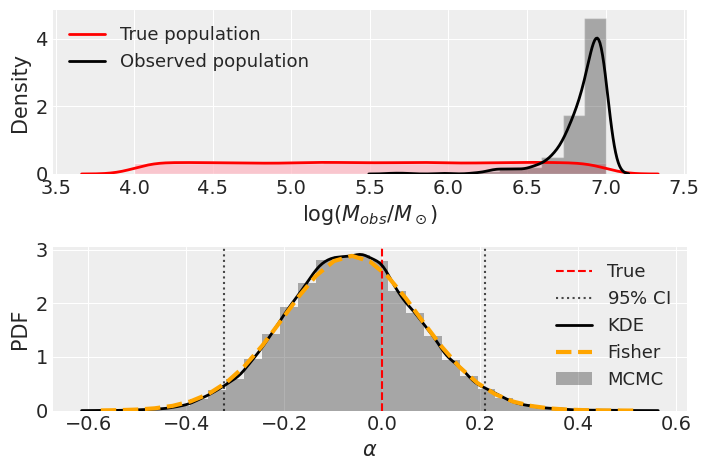

In [489]:
# Plot true and observed populations.
# Need to correct for number of detections, but this is a problem........

#gamma_lambda=Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,sig_M)*N_obs
#gamma_lambda=Gamma(alpha0_t,delta_u, M_max, M_min, rho_th, dmax,10.)*83.
gamma_lambda=0.10462625301124649*N_obs
gamma_I_lambda=0.1111121839342104*N_obs

plt.subplot(2,1,1)
plt.hist(np.log10(Mvals),density=True,bins=10,histtype = 'stepfilled',
                               color ='lightpink', alpha=0.7, edgecolor='white')
plt.hist(np.log10(M_final),density=True,bins=10,histtype = 'stepfilled',
                            color ='black', alpha=0.3, edgecolor='white')

sns.kdeplot(np.array(np.log10(Mvals)), label='True population',c='red',lw=2)
sns.kdeplot(np.array(np.log10(M_final)), label='Observed population',c='k',lw=2)
#plt.axvline(x=np.log10(np.exp(dth)), label='Threshold', c='k',alpha=0.5,ls='--',lw=2)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend(loc=2,prop={'size': 13})


# Plot distribution
plt.subplot(2,1,2)
plt.hist(alpha_samples, 30, density=True,color='k',alpha=0.3,label='MCMC')
plt.xlabel(r'$\alpha$')
plt.ylabel('PDF')
plt.axvline(alpha0_t, color='r',  linestyle='--',label='True')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.7, label=r'$95\%$ CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.7)
sns.kdeplot(alpha_samples, shade=False, color='k', lw=2, label='KDE')

# Plot Fisher matrix
_, bins_alpha, _= plt.hist(alpha_samples, 30, density=True, alpha=0.0)
Da=np.sqrt(1/gamma_lambda)
plt.plot(np.array(bins_alpha), gaussian(np.array(bins_alpha),np.median(alpha_samples),Da**2), color='orange', ls='dashed', lw=3, label='Fisher')
#DaI=np.sqrt(1/gamma_I_lambda)
#plt.plot(np.array(bins_alpha), gaussian(np.array(bins_alpha),np.median(alpha_samples),DaI**2), color='blue', ls='dashed', lw=3, label='Fisher (leading term)')


plt.legend(loc=1,prop={'size': 13})
plt.gcf().tight_layout()
plt.savefig('popfish_example_withSNRdist.pdf')

# Debugging

In [61]:
delta_u=0.0001
pdet=selection_function(alpha,delta_u,Mmin,Mmax,dmax,-3.)
print(pdet)
print(dmax)

-2190096013780.672
6.714587813373019e+18
2.3497951076860953e+21
0.9994513856784738
1428571.4285714286


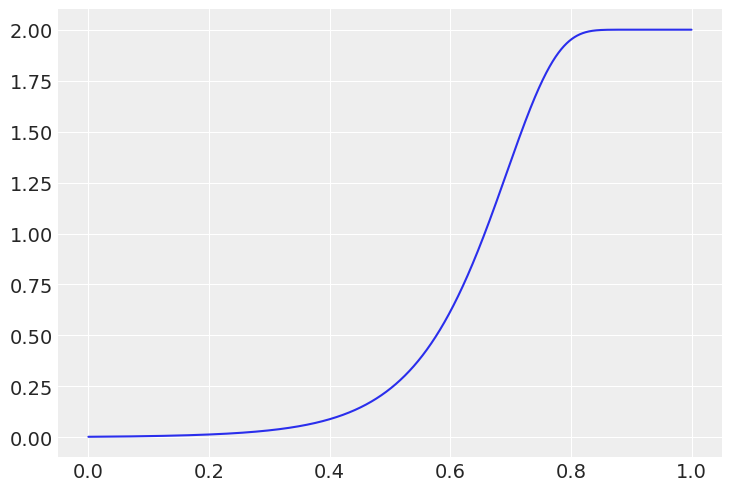

In [15]:
rhomin_inv=dmax/Mmin
rhomax_inv=dmax/Mmax
rhomin_inv=dmax/Mmax
rhomax_inv=0.
u_vals=np.arange(0.,1.,0.0001)
rho_vals=1./(rhomin_inv*((1.-(1.-((rhomax_inv/rhomin_inv)**3))*u_vals)**(1./3.)))
int_vals=erfc((rho_th-rho_vals)/np.sqrt(2.))
plt.plot(u_vals,int_vals)